# Multi Class Classification of X-Ray Images (normal, covid, virus)

# References
1. https://www.tensorflow.org/tutorials/images/classification
2. https://stackoverflow.com/questions/69812267/is-it-possible-to-use-image-dataset-from-directory-with-convolutional-autoenco
3. __[X-Ray Classification using pretained Stacked Model](https://www.analyticsvidhya.com/blog/2022/03/x-ray-classification-using-pretrained-stacked-model/)__
4. __[CNN Architectures Reviews](https://medium.com/dair-ai/papers-explained-review-01-convolutional-neural-networks-78aeff61dcb3)__
5. __[COVID CXR Image Dataset](https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research/data)__

<div class="alert alert-block alert-success">
<b>Notes</b> Pretrained stacked model vs transfer learning using single model
</div>

In [2]:
from PIL import Image 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from keras.layers import concatenate
#tf.keras.layers.concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (MaxPooling2D, 
                                    Flatten,
                                    Conv2D, 
                                    Dense,
                                    BatchNormalization,
                                    GlobalAveragePooling2D,
                                    Rescaling,
                                    Dropout)
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [3]:
from keras.layers import Dense, InputLayer, Flatten, Dropout, Rescaling, Resizing, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import pickle as pkl
import joblib as jl
import time

In [27]:
import cv2
import os
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# https://www.geeksforgeeks.org/tensorflow-js-tf-data-dataset-skip-method/
# https://www.appsloveworld.com/tensorflow/47/is-it-possible-to-split-a-tensorflow-dataset-into-train-validation-and-test-data?expand_article=1
# Ref: https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/
# Ref: https://docs.w3cub.com/tensorflow~2.3/keras/preprocessing/image_dataset_from_directory
def train_val_test_split(data_dir, split_ratio, img_width, img_height, batch_size, seed_value, shuffle_value):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir,
                              labels = 'inferred',
                              validation_split = split_ratio,
                              subset = "training",
                              seed = seed_value,
                              # color_mode='grayscale',
                              label_mode='categorical',
                              image_size = (img_height, img_width),
                              batch_size = batch_size,
                              shuffle = shuffle_value)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir,
                              labels = 'inferred',
                              validation_split = split_ratio,
                              subset = "validation",
                              seed = seed_value,
                              # color_mode='grayscale',
                              label_mode='categorical',
                              image_size = (img_height, img_width),
                              batch_size = batch_size,
                              shuffle = shuffle_value)
    print (train_ds.class_names)
    print (val_ds.class_names)
    # Next, determine how many batches of data are available in the validation set using 
    # tf.data.experimental.cardinality, and then move the two-third of them (2/3 of 30% = 20%) 
    # to a test set as follows.
    
    val_batches = tf.data.experimental.cardinality(val_ds)
    print ("Val Batches: ", val_batches, type(val_batches), (2*val_batches), val_batches.shape, val_batches.ndim)
    print('Batches for training -->', train_ds.cardinality())
    print('Batches for validating -->', val_ds.cardinality())
    
    test_ds = val_ds.take((2*val_batches) // 3) # // Floor division
    val_ds = val_ds.skip((2*val_batches) // 3)
    print('Batches for validating -->', val_ds.cardinality())
    print('Batches for testing -->', test_ds.cardinality())
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = train_val_test_split('data/', 0.2, 224, 224, 32, 123, True)

Found 1708 files belonging to 3 classes.
Using 1367 files for training.
Found 1708 files belonging to 3 classes.
Using 341 files for validation.
['covid', 'normal', 'virus']
['covid', 'normal', 'virus']
Val Batches:  tf.Tensor(11, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(22, shape=(), dtype=int64) () 0
Batches for training --> tf.Tensor(43, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(11, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(4, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(7, shape=(), dtype=int64)


## Creating Model

In [14]:
def createModel():
    base_model = tf.keras.applications.DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
        
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomZoom(0.2, 0.3, seed=123),
        #tf.keras.layers.RandomContrast(0.1, seed=123),
        tf.keras.layers.RandomBrightness(0.1, seed=123)
    ])
    normalization_layer = Rescaling(1./255) 
    
    headModel = base_model.output
    # headModel = normalization_layer(headModel)
    headModel = data_augmentation(headModel) # Add the data augmentation layer here
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)
    
#     x = BatchNormalization()(merged)
#     x = Dense(256,activation = 'relu')(x)
#     x = Dropout(0.5)(x)
#     x = BatchNormalization()(x)
#     x = Dense(128,activation = 'relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=headModel)
    
    return model

In [48]:
def createStackedModel(input_layer):
    densenet_base = DenseNet169(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)

    efficientnet_base = EfficientNetB3(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)

    for layer in densenet_base.layers:
        layer.trainable =  False
    for layer in efficientnet_base.layers:
        layer.trainable = False

    model_densenet = densenet_base(input_layer)
    model_densenet = GlobalAveragePooling2D()(model_densenet)
    output_densenet = Flatten()(model_densenet)

    model_efficientnet = efficientnet_base(input_layer)
    model_efficientnet = GlobalAveragePooling2D()(model_efficientnet)
    output_efficientnet = Flatten()(model_efficientnet)

    # It concatenates the outputs for stacking.
    merged = tf.keras.layers.Concatenate()([output_densenet, output_efficientnet])

    x = BatchNormalization()(merged)
    x = Dense(256,activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation = 'softmax')(x)

    # final model ready for the predictions
    stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)
    
    return stacked_model

In [15]:
model = createModel()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 14, 14, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 14, 14, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 7, 7, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 7, 7, 128)            94208     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 7, 7, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 864)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            110592    ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
          

 conv5_block11_concat (Conc  (None, 7, 7, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 7, 7, 992)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 7, 7, 128)            126976    ['conv5_block12_0_relu[0][0]']
 2D)      

                                                                                                  
 conv5_block15_concat (Conc  (None, 7, 7, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 7, 7, 1120)           0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_blo

 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 7, 7, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 7, 7, 1248)           4992      ['conv5_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block20_0_relu (Acti  (None, 7, 7, 1248)           0         ['conv5_block20_0_bn[0][0]']  
 vation)                                                                                          
          

 conv5_block23_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 7, 7, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_block24_0_bn (BatchN  (None, 7, 7, 1376)           5504      ['conv5_block23_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block24_0_relu (Acti  (None, 7, 7, 1376)           0         ['conv5_block24_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 7, 7, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
                                                                                                  
 conv5_block28_0_bn (BatchN  (None, 7, 7, 1504)           6016      ['conv5_block27_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 7, 7, 1632)           0         ['conv5_block30_concat[0][0]',
 atenate)                                                            'conv5_block31_2_conv[0][0]']
                                                                                                  
 conv5_block32_0_bn (BatchN  (None, 7, 7, 1632)           6528      ['conv5_block31_concat[0][0]']
 ormalization)                                                                                    
          

In [49]:
stacked_model = createStackedModel(Input(shape = (224, 224, 3)))
stacked_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_10[0][0]']            
                                                          0                                       
                                                                                                  
 efficientnetb3 (Functional  (None, 7, 7, 1536)           1078353   ['input_10[0][0]']            
 )                                                        5                                       
                                                                                            

## Data Visualization

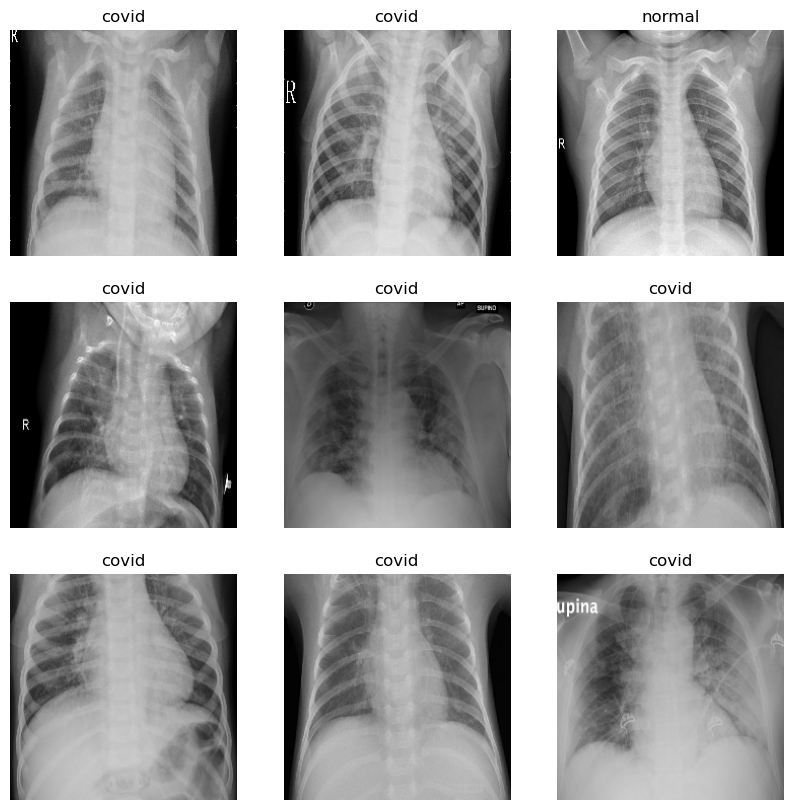

In [62]:
# https://pythonsimplified.com/image-classification-using-cnn-and-tensorflow-2/
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()[1].astype("uint8")])
        plt.axis("off")

## Compiling the Model

In [16]:
# Binary Cross Entropy is used for binary classification tasks with two classes, while Categorical Cross Entropy 
# is used for multiclass classification tasks with more than two classes
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Accuracy(),
#                                                                      tf.keras.metrics.F1Score(),
#                                                                      tf.keras.metrics.Precision(), 
#                                                                      tf.keras.metrics.Recall()])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Define Callbacks

In [11]:
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
# It stops the training if the model doesn’t get better results after some epochs.
es = EarlyStopping(monitor='val_accuracy',
                   min_delta=.01,
                   patience=6,
                   verbose=1,
                   mode='auto',
                   baseline=None,
                   restore_best_weights=True)

In [12]:
#  It reduces the rate of learning (LR) if the model doesn’t get better.
rlr = ReduceLROnPlateau(monitor="val_accuracy",
                        factor=0.01,
                        patience=6,
                        verbose=0,
                        mode="max",
                        min_delta=0.01)

## Training

In [17]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=20, callbacks=[es, rlr])

Epoch 1/20
43/43 [==============================] - 82s 2s/step - loss: 6.4959 - accuracy: 0.5106 - val_loss: 0.5981 - val_accuracy: 0.7436 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 77s 2s/step - loss: 0.9123 - accuracy: 0.5713 - val_loss: 0.6519 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 76s 2s/step - loss: 0.8611 - accuracy: 0.5852 - val_loss: 0.5756 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - 78s 2s/step - loss: 0.8391 - accuracy: 0.5999 - val_loss: 0.6636 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 81s 2s/step - loss: 0.8448 - accuracy: 0.6145 - val_loss: 0.4982 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 6/20
43/43 [==============================] - 99s 2s/step - loss: 0.7690 - accuracy: 0.6086 - val_loss: 0.4303 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 7/20
43/43 [==============================] - 103s 2s/step - loss: 0.7405 - 

In [18]:
model.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.5006 - accuracy: 0.8527


[0.50055330991745, 0.8526785969734192]

In [51]:
stacked_history = stacked_model.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=20, callbacks=[es, rlr])

Epoch 1/20
43/43 [==============================] - 193s 4s/step - loss: 0.4956 - accuracy: 0.8120 - val_loss: 0.4599 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 172s 4s/step - loss: 0.2389 - accuracy: 0.9232 - val_loss: 0.2609 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 169s 4s/step - loss: 0.1722 - accuracy: 0.9364 - val_loss: 0.1841 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - 168s 4s/step - loss: 0.1570 - accuracy: 0.9459 - val_loss: 0.1545 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 171s 4s/step - loss: 0.1559 - accuracy: 0.9532 - val_loss: 0.1526 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 6/20
43/43 [==============================] - 175s 4s/step - loss: 0.1290 - accuracy: 0.9568 - val_loss: 0.0747 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 7/20
43/43 [==============================] - 173s 4s/step - loss: 0.1

In [55]:
stacked_model.evaluate(test_ds)

7/7 [==============================] - 27s 4s/step - loss: 0.0718 - accuracy: 0.9688


[0.07181521505117416, 0.96875]

## Plot loss & accuracy

In [52]:
def plot(history):
    h = pd.DataFrame(history.history)
    h[['loss', 'val_loss']].plot()
    plt.show()
    h[['accuracy', 'val_accuracy']].plot()
    plt.show()    

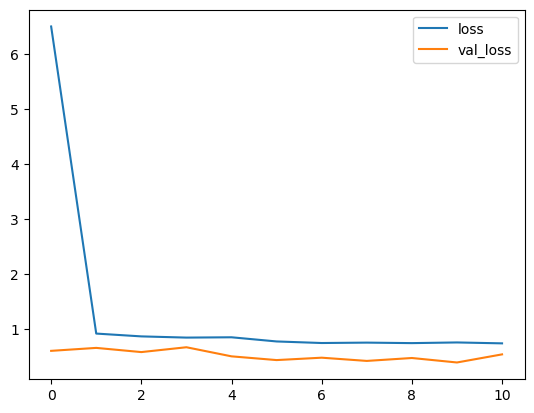

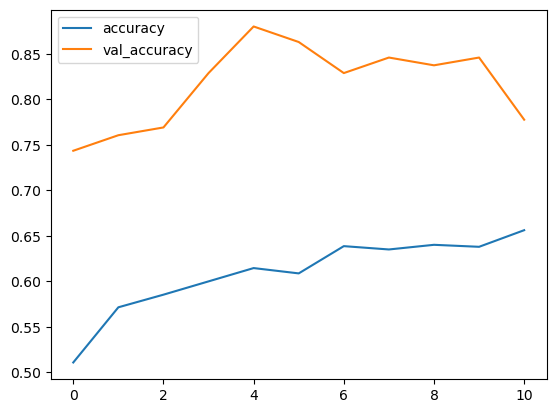

In [19]:
# plot loss and accuracy
h = pd.DataFrame(history.history)
h[['loss', 'val_loss']].plot()
plt.show()
h[['accuracy', 'val_accuracy']].plot()
plt.show()

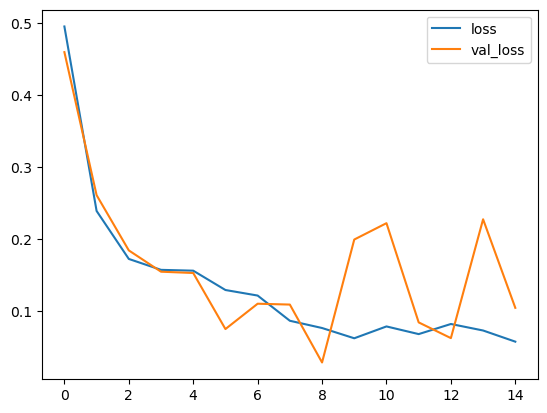

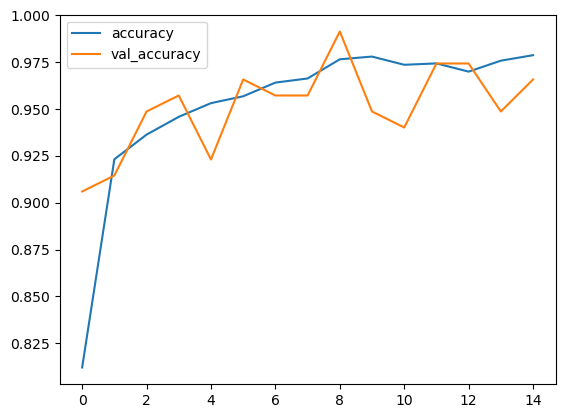

In [53]:
plot(stacked_history)

## Save & Load Models

In [20]:
# https://mljar.com/blog/save-load-scikit-learn-model/
def saveModel(model, use='pkl'):
    timestr = time.strftime("%Y%m%d_%H%M%S")
    filename = "MODEL_" + timestr
    
    # f = filename + '.' + use
    if use == 'pkl':
        pkl.dump(model, open(filename +'.'+ use, "wb"))
    else:
        jl.dump(model, filename + '.'+use)

In [21]:
def saveModel_H5(model, models_path):
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    timestr = time.strftime("%Y%m%d_%H%M%S")
    model_file_name = "MODEL_" + timestr
    model.save(models_path+model_file_name)

In [22]:
def loadModel(filename, use='pkl'):
    if use == 'pkl':
        return (pkl.load(open(filename, "rb")))
    else:
        return (jl.load(filename))

In [28]:
saveModel(model)

In [54]:
saveModel(stacked_model)

## Testing Model

In [35]:
def preprocess_image(image):
    # image = image/255
    image = cv2.resize(image, (224,224))
    return image

In [36]:
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = preprocess_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps

In [37]:
result = predict('D:/Users/ng_a/My ML Projects/X-ray-Image-Classification/chest_xray/test/NORMAL/IM-0001-0001.jpeg', model)
print (result)

1/1 [==============================] - 3s 3s/step
[[0.08911578 0.7832336  0.12765063]]


In [39]:
score = tf.nn.softmax(result[0])
class_names = ['covid', 'normal', 'virus']
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to normal with a 49.54 percent confidence.


In [40]:
result = predict('D:/Users/ng_a/My ML Projects/X-ray-Image-Classification/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', model)
print (result)

1/1 [==============================] - 0s 132ms/step
[[0.23622374 0.23569325 0.528083  ]]


In [41]:
score = tf.nn.softmax(result[0])
class_names = ['covid', 'normal', 'virus']
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to virus with a 40.11 percent confidence.


In [57]:
def predictClass(image, model):
    result = predict(image, model)
    score = tf.nn.softmax(result[0])
    class_names = ['covid', 'normal', 'virus']
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )  

In [58]:
predictClass('D:/Users/ng_a/My ML Projects/X-ray-Image-Classification/chest_xray/test/NORMAL/IM-0001-0001.jpeg', stacked_model)

1/1 [==============================] - 5s 5s/step
This image most likely belongs to normal with a 57.53 percent confidence.


In [59]:
predictClass('D:/Users/ng_a/My ML Projects/X-ray-Image-Classification/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', stacked_model)

1/1 [==============================] - 0s 304ms/step
This image most likely belongs to virus with a 57.44 percent confidence.
